In [4]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')


In [3]:
%pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 19.7 MB/s eta 0:00:00


In [5]:
# Load preprocessed data
X_train = pd.read_csv('features_train_woe.csv')
X_test = pd.read_csv('features_test_woe.csv')
y_train = pd.read_csv('target_train.csv').iloc[:, 0]
y_test = pd.read_csv('target_test.csv').iloc[:, 0]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Class distribution in training:\n{y_train.value_counts()}")

Training data shape: (2993, 3)
Test data shape: (749, 3)
Class distribution in training:
is_high_risk
0    1925
1    1068
Name: count, dtype: int64


1. SMOTE for Class Balancing

In [6]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training shape: {X_train.shape}")
print(f"Balanced training shape: {X_train_balanced.shape}")
print(f"Balanced class distribution:\n{pd.Series(y_train_balanced).value_counts()}")

Original training shape: (2993, 3)
Balanced training shape: (3850, 3)
Balanced class distribution:
is_high_risk
0    1925
1    1925
Name: count, dtype: int64


2. MLflow Setup and Model Training

In [15]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Example: assuming `X_train` and `y_train` used for training
signature = infer_signature(X_train, best_model.predict(X_train))
input_example = X_train.iloc[:5]  # or use .head()

mlflow.sklearn.log_model(
    best_model,
    model_name,
    registered_model_name=model_name,
    signature=signature,
    input_example=input_example
)


2025/07/01 12:00:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'Logistic_Regression'.
Created version '1' of model 'Logistic_Regression'.


In [16]:
# Initialize MLflow
mlflow.set_experiment("Customer_Risk_Prediction")

def evaluate_model(model, X_test, y_test, y_pred, y_pred_proba):
    """Calculate all evaluation metrics"""
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    return metrics

def train_and_log_model(model_name, model, X_train, y_train, X_test, y_test, params=None):
    """Train model and log to MLflow"""
    with mlflow.start_run(run_name=model_name):
        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        metrics = evaluate_model(model, X_test, y_test, y_pred, y_pred_proba)

        # Log parameters
        if params:
            mlflow.log_params(params)

        # Log metrics
        mlflow.log_metrics(metrics)

        # Log model
        mlflow.sklearn.log_model(model, f"{model_name}_model")

        print(f"\n{model_name} Results:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

        return model, metrics

# Model configurations
models_config = {
    'Logistic_Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision_Tree': DecisionTreeClassifier(random_state=42),
    'Random_Forest': RandomForestClassifier(random_state=42),
    'Gradient_Boosting': GradientBoostingClassifier(random_state=42)
}

# Train baseline models
baseline_results = {}
for name, model in models_config.items():
    trained_model, metrics = train_and_log_model(
        f"{name}_Baseline", model, X_train_balanced, y_train_balanced, X_test, y_test
    )
    baseline_results[name] = metrics

2025/07/01 12:00:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/01 12:00:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/01 12:00:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Logistic_Regression_Baseline Results:
accuracy: 0.9453
precision: 0.8979
recall: 0.9551
f1_score: 0.9256
roc_auc: 0.9826


2025/07/01 12:00:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Decision_Tree_Baseline Results:
accuracy: 0.9493
precision: 0.8990
recall: 0.9663
f1_score: 0.9314
roc_auc: 0.9848


2025/07/01 12:00:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/01 12:01:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Random_Forest_Baseline Results:
accuracy: 0.9479
precision: 0.8931
recall: 0.9700
f1_score: 0.9300
roc_auc: 0.9852


2025/07/01 12:01:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/01 12:01:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Gradient_Boosting_Baseline Results:
accuracy: 0.9493
precision: 0.8990
recall: 0.9663
f1_score: 0.9314
roc_auc: 0.9875


3. Hyperparameter Tuning

In [9]:
# Hyperparameter grids
param_grids = {
    'Random_Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'Gradient_Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [3, 5, 7]
    },
    'Logistic_Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
}

tuned_results = {}

for model_name in ['Random_Forest', 'Gradient_Boosting', 'Logistic_Regression']:
    print(f"\nTuning {model_name}...")

    with mlflow.start_run(run_name=f"{model_name}_Tuned"):
        # Grid search
        grid_search = GridSearchCV(
            models_config[model_name],
            param_grids[model_name],
            cv=3,
            scoring='roc_auc',
            n_jobs=-1
        )

        grid_search.fit(X_train_balanced, y_train_balanced)

        # Best model predictions
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        metrics = evaluate_model(best_model, X_test, y_test, y_pred, y_pred_proba)

        # Log best parameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(best_model, f"{model_name}_tuned_model")

        tuned_results[model_name] = {
            'model': best_model,
            'params': grid_search.best_params_,
            'metrics': metrics
        }

        print(f"Best params: {grid_search.best_params_}")
        print(f"Best ROC-AUC: {metrics['roc_auc']:.4f}")


Tuning Random_Forest...


2025/07/01 11:48:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/01 11:48:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best ROC-AUC: 0.9868

Tuning Gradient_Boosting...


2025/07/01 11:49:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/01 11:49:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/01 11:49:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best ROC-AUC: 0.9875

Tuning Logistic_Regression...


2025/07/01 11:49:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC-AUC: 0.9828


4. Model Comparison and Best Model Selection

Model Comparison (Tuned Models):
                     accuracy  precision  recall  f1_score  roc_auc
Random_Forest          0.9479     0.8931  0.9700    0.9300   0.9868
Gradient_Boosting      0.9493     0.8990  0.9663    0.9314   0.9875
Logistic_Regression    0.9453     0.8979  0.9551    0.9256   0.9828


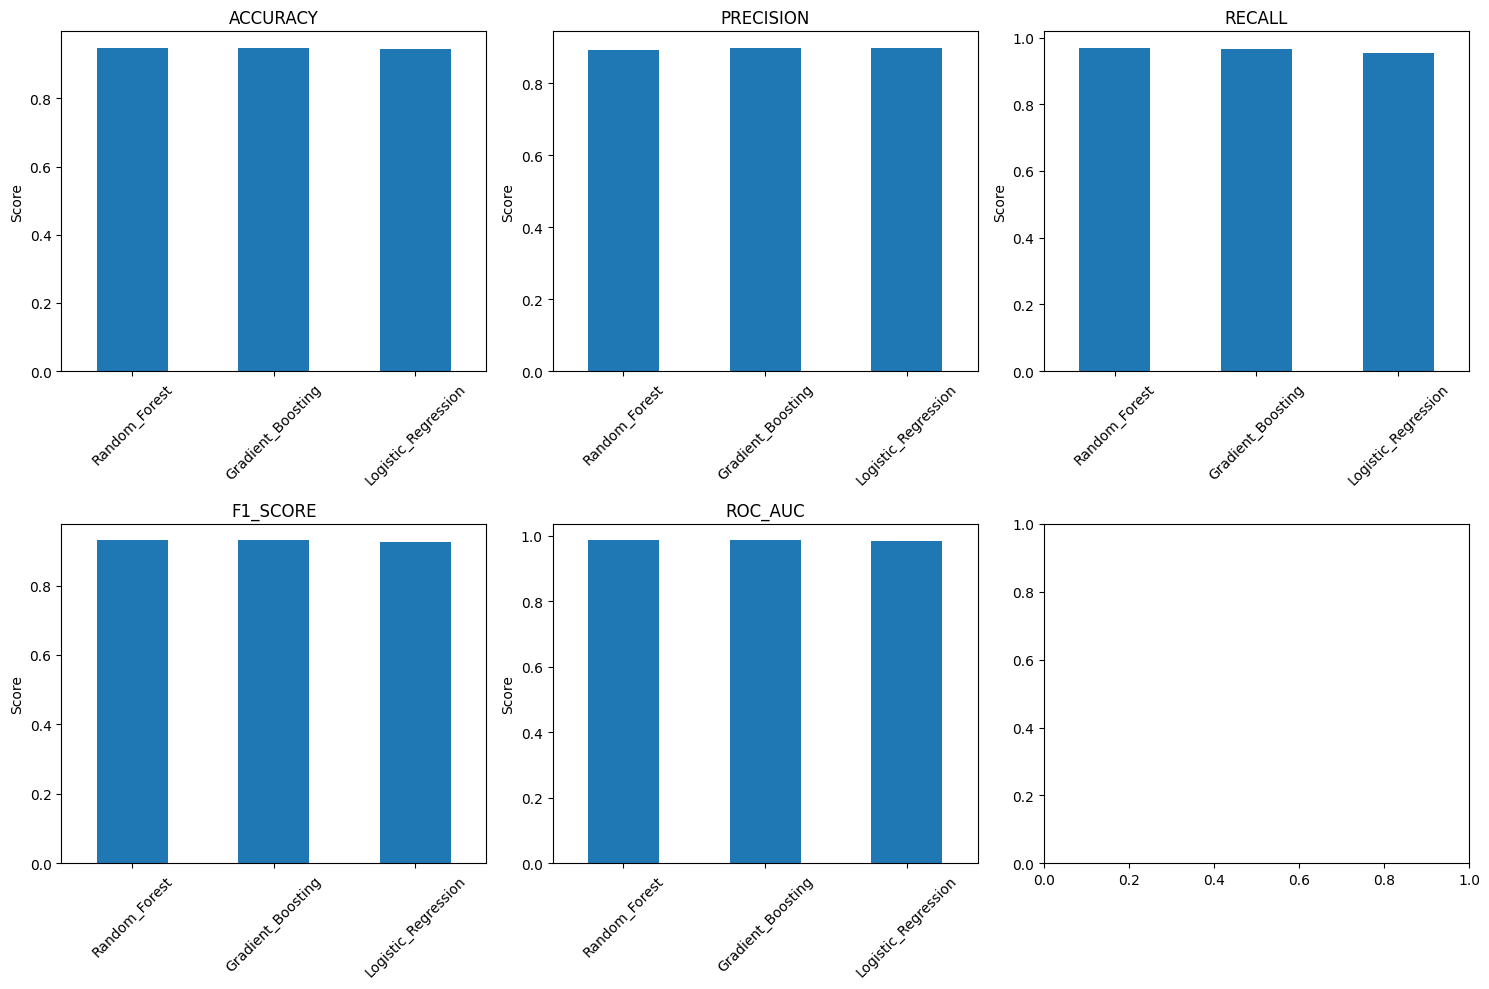


Best Model: Gradient_Boosting
Best ROC-AUC: 0.9875


In [10]:
# Compare all models
comparison_df = pd.DataFrame({
    name: metrics for name, result in tuned_results.items()
    for metrics in [result['metrics']]
}).T

print("Model Comparison (Tuned Models):")
print(comparison_df.round(4))

# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i//3, i%3]
    comparison_df[metric].plot(kind='bar', ax=ax)
    ax.set_title(f'{metric.upper()}')
    ax.set_ylabel('Score')
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Select best model based on ROC-AUC
best_model_name = comparison_df['roc_auc'].idxmax()
best_model = tuned_results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"Best ROC-AUC: {comparison_df.loc[best_model_name, 'roc_auc']:.4f}")

5. Register Best Model in MLflow

2025/07/01 11:51:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/01 11:51:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'CustomerRiskModel'.
Created version '1' of model 'CustomerRiskModel'.


Best model registered and saved!
Model URI: models:/m-8fd757933d2540b8b1b201b7dae0aa1d

Detailed Evaluation - Gradient_Boosting:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       482
           1       0.90      0.97      0.93       267

    accuracy                           0.95       749
   macro avg       0.94      0.95      0.95       749
weighted avg       0.95      0.95      0.95       749



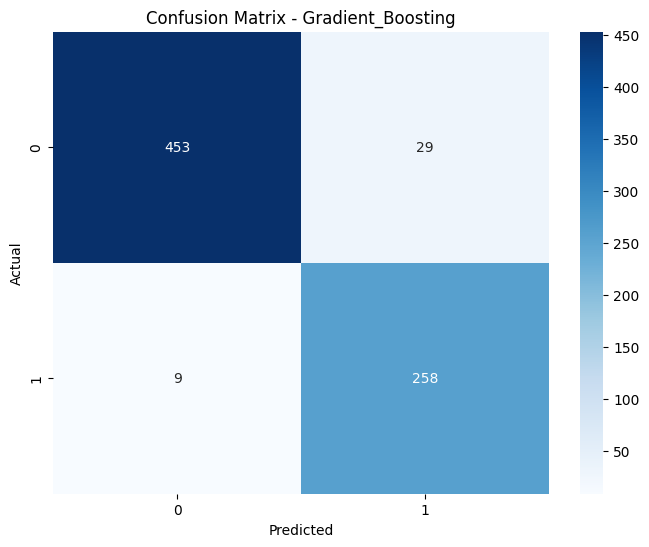

In [11]:
# Register the best model
with mlflow.start_run(run_name=f"Best_Model_{best_model_name}"):
    # Final predictions with best model
    y_pred_final = best_model.predict(X_test)
    y_pred_proba_final = best_model.predict_proba(X_test)[:, 1]

    # Final metrics
    final_metrics = evaluate_model(best_model, X_test, y_test, y_pred_final, y_pred_proba_final)

    # Log everything
    mlflow.log_params(tuned_results[best_model_name]['params'])
    mlflow.log_metrics(final_metrics)

    # Log model
    model_info = mlflow.sklearn.log_model(
        best_model,
        "best_customer_risk_model",
        registered_model_name="CustomerRiskModel"
    )

    # Save locally
    joblib.dump(best_model, 'best_customer_risk_model.pkl')

    print("Best model registered and saved!")
    print(f"Model URI: {model_info.model_uri}")

# Detailed evaluation of best model
print(f"\nDetailed Evaluation - {best_model_name}:")
print("Classification Report:")
print(classification_report(y_test, y_pred_final))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

6. Feature Importance Analysis

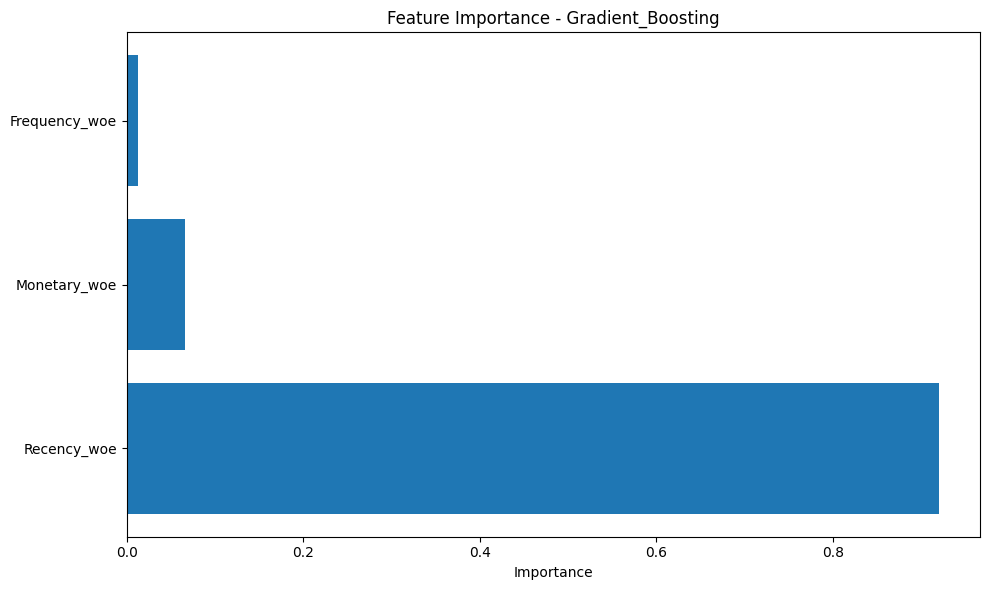

Top Features:
         feature  importance
0    Recency_woe    0.920910
1   Monetary_woe    0.066148
2  Frequency_woe    0.012942

Model training pipeline completed successfully!
Best model: Gradient_Boosting with ROC-AUC: 0.9875


In [12]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    print("Top Features:")
    print(feature_importance.head())

print("\nModel training pipeline completed successfully!")
print(f"Best model: {best_model_name} with ROC-AUC: {final_metrics['roc_auc']:.4f}")

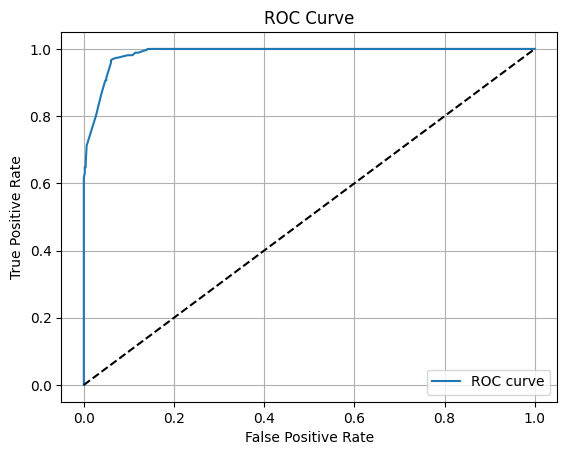

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

